<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/gradient-descent/grad_descent_dls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import numpy as np
import pandas as pd
import scipy.linalg as sla
import matplotlib.pyplot as plt


from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn import datasets
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [20]:
%matplotlib inline

### Create a function

In [2]:
def f(x):
    """
    :param x: np.array(np.float) vector length 2
    :return: np.float
    """
    return np.sum(np.sin(x)**2)

### Analytical approach to calculate gradient

In [5]:
def grad_f(x):
    """
    gradinet of f func.
    :param x: np.array[2]: float vector length 2
    :return: np.array[2]: float vector length  2
    """
    grad_x = 2 * np.sin(x[0]) * np.cos(x[0])
    grad_y = 2 * np.sin(x[1]) * np.cos(x[1])
    return np.array([grad_x, grad_y])

#### Bathe in tests

In [6]:
assert np.allclose(grad_f(np.array([1, 2])),
                   np.array([0.90929743, -0.7568025])), "Something's wrong!"

### Implement gradient descent

In [7]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    grad descent for 2 variables
        :param f: scalar f for 2 vars
        :param grad_f: func returns grad of func f (only for grad_f impleimentation)
        :param lr: learning rate
        :param num_iter: number of alg iterations
        :return: np.array[num_iter, 2]  (x, f(x))
    """
    if x0 is None:
        x0 = np.random.random(2)

    # saving the learning history
    history = []

    # grad cycle
    curr_x = x0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_x, f(curr_x)))
        history.append(entry)

        curr_x -= grad_f(entry) * lr

    return np.vstack(history)

#### Visualize

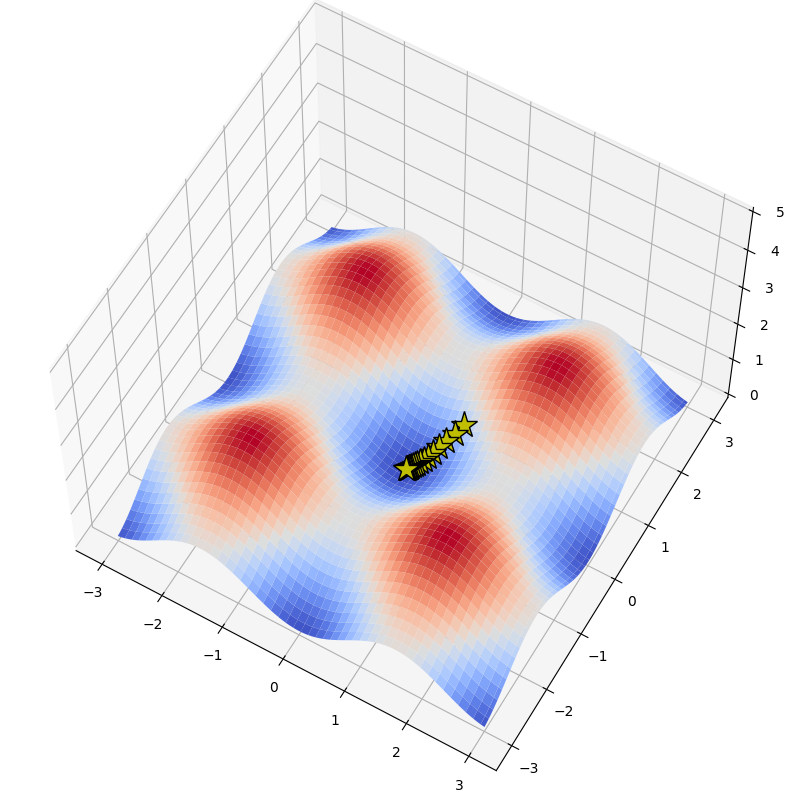

In [21]:
steps = grad_descent_2d(f, grad_f, lr=0.1, num_iter=20)
path = []
X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

fig = plt.figure(figsize=(16, 10))
ax = fig.add_subplot(projection='3d')

zs = np.array([f(np.array([x,y]))
              for x, y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)


ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
        marker='*', markersize=20, zorder=3,
        markerfacecolor='y', lw=3, c='black')

ax.set_zlim(0, 5)
ax.view_init(elev=60)
plt.show()

In [17]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

path = []

X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

fig = plt.figure(figsize=(16, 10))
ax = fig.gca(projection='3d')

zs = np.array([f(np.array([x,y]))
              for x, y in zip(np.ravel(X), np.ravel(Y))])
Z = zs.reshape(X.shape)


ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, zorder=2)

ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
        marker='*', markersize=20, zorder=3,
        markerfacecolor='y', lw=3, c='black')

ax.set_zlim(0, 5)
ax.view_init(elev=60)

plt.savefig('plot.png')  # Save the plot as an image file
plt.close()  # Close the interactive plot

from PIL import Image

img = Image.open('plot.png')
img.show()


TypeError: ignored

<Figure size 1600x1000 with 0 Axes>